In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.segy.segy import _read_segy
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

In [2]:
# Load data
dfs = pd.read_excel('../data/2022_Gravity_Corrected.xlsx', sheet_name=None)
group5_df1 = dfs['GROUP5 CG5-1']
group5_df2 = dfs['GROUP5 CG5-2']
group1_df = dfs['GROUP1 CG5-2']

# Filter out base readings
group5_df1 = group5_df1[group5_df1['Base'] != 'base']
group5_df2 = group5_df2[group5_df2['Base'] != 'base']
group1_df = group1_df[group1_df['Base'] != 'base']

# Combine Group 5 DataFrames
group5_combined = pd.concat([group5_df1, group5_df2], ignore_index=True)

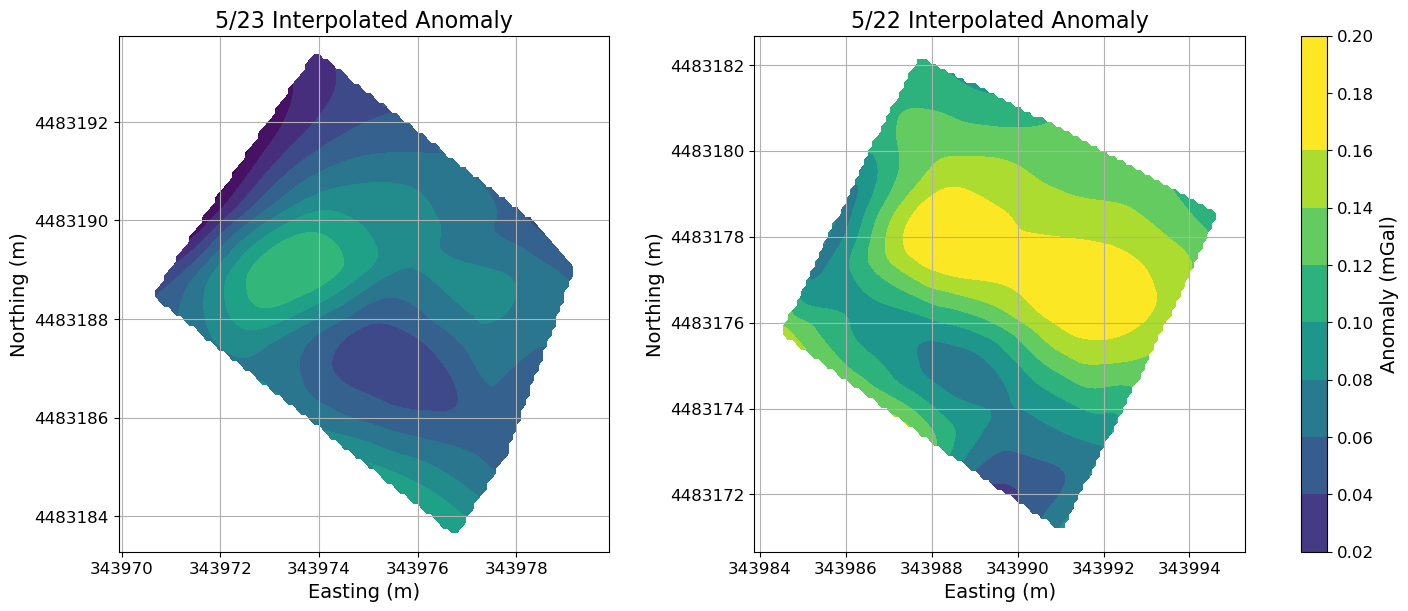

In [19]:
# Compute original global min from both groups
original_min = pd.concat([group1_df['Corrected'], group5_combined['Corrected']]).min()

# Normalize by subtracting the global minimum
group1_df.loc[:, 'normalized'] = group1_df['Corrected'] - original_min
group5_combined.loc[:, 'normalized'] = group5_combined['Corrected'] - original_min

# Set colorbar limits (vmin now 0)
vmin = 0
vmax = pd.concat([group1_df['normalized'], group5_combined['normalized']]).max()

# Plotting settings
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
title_fs = 16
label_fs = 14
tick_fs = 12
cbar_fs = 14

# --- Group 1 (Left Plot) ---
x2 = group1_df['Easting (m)']
y2 = group1_df['Northing (m)']
z2 = group1_df['normalized']
xi2 = np.linspace(x2.min(), x2.max(), 100)
yi2 = np.linspace(y2.min(), y2.max(), 100)
xi2, yi2 = np.meshgrid(xi2, yi2)
zi2 = griddata((x2, y2), z2, (xi2, yi2), method='cubic')

c1 = axs[0].contourf(xi2, yi2, zi2, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("5/23 Interpolated Anomaly", fontsize=title_fs)
axs[0].set_xlabel("Easting (m)", fontsize=label_fs)
axs[0].set_ylabel("Northing (m)", fontsize=label_fs)
axs[0].tick_params(labelsize=tick_fs)
axs[0].axis('equal')
axs[0].grid(True)
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# --- Group 5 (Right Plot) ---
x1 = group5_combined['Easting (m)']
y1 = group5_combined['Northing (m)']
z1 = group5_combined['normalized']
xi1 = np.linspace(x1.min(), x1.max(), 100)
yi1 = np.linspace(y1.min(), y1.max(), 100)
xi1, yi1 = np.meshgrid(xi1, yi1)
zi1 = griddata((x1, y1), z1, (xi1, yi1), method='cubic')

c2 = axs[1].contourf(xi1, yi1, zi1, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("5/22 Interpolated Anomaly", fontsize=title_fs)
axs[1].set_xlabel("Easting (m)", fontsize=label_fs)
axs[1].set_ylabel("Northing (m)", fontsize=label_fs)
axs[1].tick_params(labelsize=tick_fs)
axs[1].axis('equal')
axs[1].grid(True)
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Shared colorbar
cbar = fig.colorbar(c2, ax=axs, location='right')
cbar.set_label('Anomaly (mGal)', fontsize=cbar_fs)
cbar.ax.tick_params(labelsize=tick_fs)

plt.savefig("../figures/interpolated_grav_anomaly", dpi=300)
plt.show()


In [5]:
# Load in sulpher cave DEM
df_dem = pd.read_csv("../data/sulfur_cave_DEM_GPS_20220526.csv")

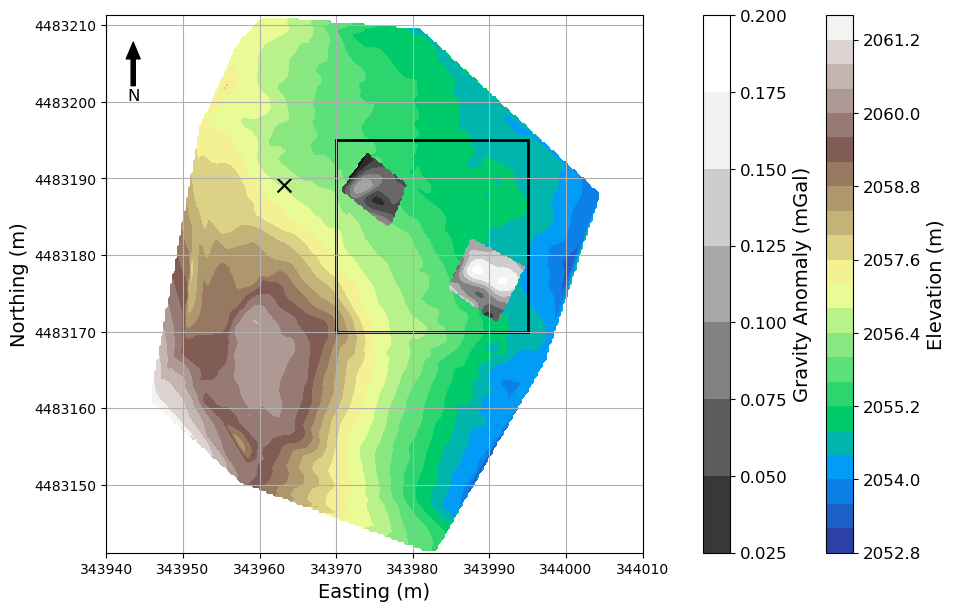

In [54]:
# Set up single figure and axis
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

# Plot DEM background
elev_plot = ax.contourf(xi, yi, zi_elev, levels=20, cmap='terrain')

# Interpolate and overlay both anomalies on top
# Store the second contourf for the anomaly colorbar
anomaly_plot = None
for df_group, label in zip(
    [group1_df, group5_combined],
    ["5/23 Anomaly", "5/22 Anomaly"]
):
    zi_anomaly = griddata(
        (df_group["Easting (m)"], df_group["Northing (m)"]),
        df_group["normalized"],
        (xi, yi),
        method='cubic'
    )
    anomaly_plot = ax.contourf(xi, yi, zi_anomaly, levels=6, cmap='gray', vmin=vmin, vmax=vmax)

# North arrow
ax.annotate(
    'N',
    xy=(0.05, 0.95), xytext=(0.05, 0.85),
    arrowprops=dict(facecolor='black', width=3, headwidth=10),
    ha='center', va='center', fontsize=12,
    xycoords='axes fraction'
)

# Cave entrance
ax.scatter(343963.25, 4483189.21, marker="x", color="k", s=100)

# Shared colorbars
# DEM colorbar
cbar1 = fig.colorbar(elev_plot, ax=ax, location='right', pad=0.02)
cbar1.set_label("Elevation (m)", fontsize=14)
cbar1.ax.tick_params(labelsize=12)

# Gravity anomaly colorbar (placed slightly outside plot)
cbar2 = fig.colorbar(anomaly_plot, ax=ax)
cbar2.set_label("Gravity Anomaly (mGal)", fontsize=14)
cbar2.ax.tick_params(labelsize=12)

# Add dashed box showing zoom-in area
rect = plt.Rectangle(
    (343970, 4483170),
    25, 25,
    linewidth=2,
    edgecolor='black',
    facecolor='none',
)
ax.add_patch(rect)

# scale x axis
ax.set_xlim(343940, 344010)

# Labels and formatting
ax.set_xlabel("Easting (m)", fontsize=14)
ax.set_ylabel("Northing (m)", fontsize=14)
ax.set_aspect('equal')
ax.grid(True)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Save and show
plt.show()
